In [1]:
from sympy import sqrt, I, series, limit, symbols, factorial, cos, sin
from sympy.core.add import Add
from sympy.core.mul import Mul
from sympy.physics.secondquant import B, Bd, CreateBoson, AnnihilateBoson, Commutator, KroneckerDelta

In [2]:
# Eliminates all powers
def flatten(expr):
    expr = expr.expand()
    if expr.is_Add: return Add(*[flatten(arg) for arg in expr.args])
    elif expr.is_Mul: 
        factors = []
        for arg in expr.args:
            if arg.is_Pow and arg.exp.is_Integer and arg.exp > 0:
                factors.extend([arg.base] * int(arg.exp))
            else:
                factors.append(flatten(arg))
        return Mul(*factors, evaluate=False)
    elif expr.is_Pow and expr.exp.is_Integer and expr.exp > 0:
        return Mul(*[flatten(expr.base)] * int(expr.exp), evaluate=False)
    return expr

# Puts a polynomial expression of bosonic operators into the equivalent normal ordered form
def wick(expr):
    expr = flatten(expr)
    if expr.is_Add: return Add(*[wick(arg) for arg in expr.args])
    elif expr.is_Mul:
        commuting = [x for x in expr.args if not isinstance(x, AnnihilateBoson) and not isinstance(x, CreateBoson)]
        noncommuting = [x for x in expr.args if isinstance(x, AnnihilateBoson) or isinstance(x, CreateBoson)]
        n = len(noncommuting)
        if n == 0 or n == 1: return expr
        else:
            for i in range(n-1):
                c = Commutator(noncommuting[i], noncommuting[i+1])
                if isinstance(c, KroneckerDelta): c = 0
                if isinstance(noncommuting[i], AnnihilateBoson) and isinstance(noncommuting[i+1], CreateBoson):
                    expr1 = [c] + noncommuting[:i] + noncommuting[i+2:]
                    expr2 = noncommuting[:i] + [noncommuting[i+1], noncommuting[i]] + noncommuting[i+2:]
                    return wick(Mul(*commuting) * (wick(Mul(*expr1)) + wick(Mul(*expr2))))
            return expr
    else:
        return expr

# Computes the vacuum expectation value of a polynomial expression of bosonic operators
vev = lambda expr: Add(*[x for x in wick(expr).args if not any(isinstance(y, AnnihilateBoson) or isinstance(y, CreateBoson) for y in x.args)])

In [3]:
# Verifies the above functions work by using them to reproduce the main results of the paper:
# Quantum Theory of the Josephson Junction between Finite Islands

ng, x = symbols('n_g x', real = True)
N, EJ, EC = symbols("N E_J E_C", positive = True)
u_s, u_p, u_m, u_0 = symbols('u_s, u_p, u_m, u_0')
eps = sqrt(2*EC*EJ + EJ**2/N**2)
u_p = (EJ + N * eps) / sqrt(4 * N * eps * EJ)
u_m = (EJ - N * eps) / sqrt(4 * N * eps * EJ)
u_0 = ng * sqrt(2 * EC**2 * EJ / eps**3)
u_s = u_p + u_m

b = B('b')
bd = Bd('b')
a = u_p*b - u_m*bd + I*u_0*(u_p+u_m)
ad = u_p*bd - u_m*b - I*u_0*(u_p+u_m)
p = (a-ad)/(I*sqrt(2))
pp = p - ng/sqrt(N)

expr = -EC/2*(b*pp*ad*p*a*bd - pp*ad*p*a)
freq = eps + vev(expr)
assert((freq - series(freq, ng, 0, 3)).simplify()==0)
assert(freq.diff(ng).subs(ng,0)==0)
freq_0 = limit(freq.subs(ng, 0).subs(N, x * EJ/EC), x, "oo")
freq_2 = limit((N**2 * (freq.diff(ng, 2)/2).subs(ng, 0)).subs(N, x * EJ/EC), x, "oo")*(ng/N)**2
freq = (limit(((freq_0+freq_2)/sqrt(EC * EJ)).subs(EC, x * EJ), x, 0) * sqrt(EC * EJ)).simplify()
print('Transmon qubit frequency times Planck\'s constant:')
display(freq)

zeroth_order = vev(sqrt(N)*p)
first_order = vev(-ad*p*a/(4*sqrt(N)))
for k in range(1,5): first_order += EC*sqrt(N)/(2*eps*k*factorial(k)) * vev(p*bd**k) * (vev(b**k*pp*ad*p*a) + vev(b**k*ad*p*a*pp))
all_orders = (zeroth_order + first_order).simplify()
all_orders.diff(ng, 3).subs(ng, 0).simplify()
suscept = all_orders.diff(ng)
assert((suscept - series(suscept, ng, 0, 3)).simplify() == 0)
assert(suscept.diff(ng).subs(ng, 0) == 0)
suscept_0 = limit(suscept.subs(ng, 0).subs(N, x * EJ/EC), x, "oo")
suscept_2 = limit((N**4 * (suscept.diff(ng, 2)/2).subs(ng, 0)).subs(N, x * EJ/EC), x, "oo")*(ng**2)/(N**4)
suscept = suscept_0 + suscept_2
print('Transmon dimensionless charge susceptibility:')
display(suscept.simplify())

Transmon qubit frequency times Planck's constant:


sqrt(2)*sqrt(E_C)*sqrt(E_J)*(N**2 - n_g**2/4)/N**2

Transmon dimensionless charge susceptibility:


1 - 3*E_J*n_g**2/(4*E_C*N**4)

In [4]:
x = B('x')* Bd('x')*(Bd('x'))*(B('y')*Bd('y'))
wick(x)

2*CreateBoson(x) + CreateBoson(x)*CreateBoson(x)*AnnihilateBoson(x) + CreateBoson(x)*CreateBoson(x)*CreateBoson(y)*AnnihilateBoson(x)*AnnihilateBoson(y) + 2*CreateBoson(x)*CreateBoson(y)*AnnihilateBoson(y)

In [5]:
# define spin operators
S = symbols('S', positive = True)
th = symbols('theta', real = True)
a, ad = B('a'), Bd('a')
sz = S - ad*a
sp = sqrt(2*S)*(1-ad*a/(4*S))*a
sm = ad*sqrt(2*S)*(1-ad*a/(4*S))

sx = (sp+sm)/2
Sz = sz*cos(th)-sx*sin(th)
Sx = sx*cos(th)+sz*sin(th)

# define bosonic operators
hw = symbols(r'\hbar\omega', positive = True)
l = symbols(r'\lambda', real = True)
c, cd = B('c'), Bd('c')
b, bd = c - sqrt(2*S)*l*cos(th)/(4*hw), cd - sqrt(2*S)*l*cos(th)/(4*hw)

# define Hamiltonians
J, U = symbols(r'J U', positive = True)
gm = symbols(r'\gamma_-', real = True)
H_M = -J * Sx + U/(2*S)*Sz**2 - (gm/2)*Sz
H_L = hw*bd*b
H_LM = l/(2*sqrt(2*S))*Sz*(b+bd)
H = (H_M + H_L + H_LM).expand()

sqrtS = symbols(r'\sqrt{S}', positive = True)
H_ = []
max_order = 4
h = (H/S).subs(S, sqrtS**2)
for i in range(max_order+1):
    H_.append(((h.series(1/sqrtS, 0,i+1).removeO() - h.series(1/sqrtS, 0,i).removeO()).subs(sqrtS, sqrt(S))*S).expand())


In [6]:
display(H_[0])
display(H_[1])
display(H_[2])
display(H_[3])
display(H_[4])

-J*S*sin(theta) + S*U*cos(theta)**2/2 - S*\gamma_-*cos(theta)/2 - S*\lambda**2*cos(theta)**2/(8*\hbar\omega)

-sqrt(2)*J*sqrt(S)*cos(theta)*AnnihilateBoson(a)/2 - sqrt(2)*J*sqrt(S)*cos(theta)*CreateBoson(a)/2 - sqrt(2)*sqrt(S)*U*sin(theta)*cos(theta)*AnnihilateBoson(a)/2 - sqrt(2)*sqrt(S)*U*sin(theta)*cos(theta)*CreateBoson(a)/2 + sqrt(2)*sqrt(S)*\gamma_-*sin(theta)*AnnihilateBoson(a)/4 + sqrt(2)*sqrt(S)*\gamma_-*sin(theta)*CreateBoson(a)/4 + sqrt(2)*sqrt(S)*\lambda**2*sin(theta)*cos(theta)*AnnihilateBoson(a)/(8*\hbar\omega) + sqrt(2)*sqrt(S)*\lambda**2*sin(theta)*cos(theta)*CreateBoson(a)/(8*\hbar\omega)

J*sin(theta)*CreateBoson(a)*AnnihilateBoson(a) + U*sin(theta)**2*AnnihilateBoson(a)*CreateBoson(a)/4 + U*sin(theta)**2*AnnihilateBoson(a)**2/4 + U*sin(theta)**2*CreateBoson(a)*AnnihilateBoson(a)/4 + U*sin(theta)**2*CreateBoson(a)**2/4 - U*cos(theta)**2*CreateBoson(a)*AnnihilateBoson(a) + \gamma_-*cos(theta)*CreateBoson(a)*AnnihilateBoson(a)/2 + \hbar\omega*CreateBoson(c)*AnnihilateBoson(c) - \lambda*sin(theta)*AnnihilateBoson(a)*AnnihilateBoson(c)/4 - \lambda*sin(theta)*AnnihilateBoson(a)*CreateBoson(c)/4 - \lambda*sin(theta)*CreateBoson(a)*AnnihilateBoson(c)/4 - \lambda*sin(theta)*CreateBoson(a)*CreateBoson(c)/4 + \lambda**2*cos(theta)**2*CreateBoson(a)*AnnihilateBoson(a)/(4*\hbar\omega)

sqrt(2)*J*cos(theta)*CreateBoson(a)*AnnihilateBoson(a)**2/(8*sqrt(S)) + sqrt(2)*J*cos(theta)*CreateBoson(a)**2*AnnihilateBoson(a)/(8*sqrt(S)) + sqrt(2)*U*sin(theta)*cos(theta)*AnnihilateBoson(a)*CreateBoson(a)*AnnihilateBoson(a)/(4*sqrt(S)) + sqrt(2)*U*sin(theta)*cos(theta)*CreateBoson(a)*AnnihilateBoson(a)*CreateBoson(a)/(4*sqrt(S)) + 3*sqrt(2)*U*sin(theta)*cos(theta)*CreateBoson(a)*AnnihilateBoson(a)**2/(8*sqrt(S)) + 3*sqrt(2)*U*sin(theta)*cos(theta)*CreateBoson(a)**2*AnnihilateBoson(a)/(8*sqrt(S)) - sqrt(2)*\gamma_-*sin(theta)*CreateBoson(a)*AnnihilateBoson(a)**2/(16*sqrt(S)) - sqrt(2)*\gamma_-*sin(theta)*CreateBoson(a)**2*AnnihilateBoson(a)/(16*sqrt(S)) - sqrt(2)*\lambda*cos(theta)*CreateBoson(a)*AnnihilateBoson(a)*AnnihilateBoson(c)/(4*sqrt(S)) - sqrt(2)*\lambda*cos(theta)*CreateBoson(a)*AnnihilateBoson(a)*CreateBoson(c)/(4*sqrt(S)) - sqrt(2)*\lambda**2*sin(theta)*cos(theta)*CreateBoson(a)*AnnihilateBoson(a)**2/(32*sqrt(S)*\hbar\omega) - sqrt(2)*\lambda**2*sin(theta)*cos(theta)*Cr

-U*sin(theta)**2*AnnihilateBoson(a)*CreateBoson(a)*AnnihilateBoson(a)**2/(16*S) - U*sin(theta)**2*AnnihilateBoson(a)*CreateBoson(a)**2*AnnihilateBoson(a)/(16*S) - U*sin(theta)**2*CreateBoson(a)*AnnihilateBoson(a)**2*CreateBoson(a)/(16*S) - U*sin(theta)**2*CreateBoson(a)*AnnihilateBoson(a)**3/(16*S) - U*sin(theta)**2*CreateBoson(a)**2*AnnihilateBoson(a)*CreateBoson(a)/(16*S) - U*sin(theta)**2*CreateBoson(a)**2*AnnihilateBoson(a)**2/(8*S) - U*sin(theta)**2*CreateBoson(a)**3*AnnihilateBoson(a)/(16*S) + U*cos(theta)**2*CreateBoson(a)*AnnihilateBoson(a)*CreateBoson(a)*AnnihilateBoson(a)/(2*S) + \lambda*sin(theta)*CreateBoson(a)*AnnihilateBoson(a)**2*AnnihilateBoson(c)/(16*S) + \lambda*sin(theta)*CreateBoson(a)*AnnihilateBoson(a)**2*CreateBoson(c)/(16*S) + \lambda*sin(theta)*CreateBoson(a)**2*AnnihilateBoson(a)*AnnihilateBoson(c)/(16*S) + \lambda*sin(theta)*CreateBoson(a)**2*AnnihilateBoson(a)*CreateBoson(c)/(16*S)

In [7]:
from sympy import solve
t = symbols('t', real = True)
t_ = solve((H_[0].diff(th).subs(sin(th), 2*t/(1+t**2)).subs(cos(th), (1-t**2)/(1+t**2))*(1+t**2)**2*2*hw/S).simplify(), t)
freqs = [sqrt(J*(J*(1+t**2)**2/(4*t**2) + 2*U*t/(1+t**2))) for t in t_] 

100%|██████████| 40/40 [00:15<00:00,  2.53it/s]
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


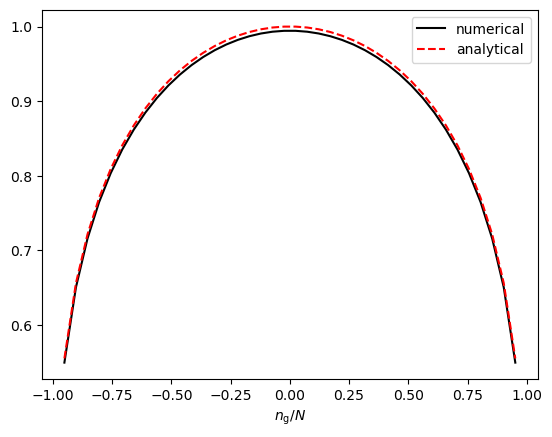

In [8]:
# Verifies the analytical formula for frequency reproduces the numerical result from the paper:
# Quantum Theory of the Josephson Junction between Finite Islands

from scipy.linalg import eigh_tridiagonal
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sympy import Integer, solve

def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1)-ng)**2
    n = np.arange(-N, N)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - (n*(n+1)))
    eigs =  eigh_tridiagonal(D, O, eigvals_only = True, select = 'i', select_range = (k, k), tol = 1e-14)
    return eigs[0]

EC=1
EJ=10**3
N=10**6/2
ngs = np.array([int(ng) for ng in np.linspace(-N, N, 42)[1:-1]])
numerical = np.array([E(1, EC, EJ, ng, N) - E(0, EC, EJ, ng, N) for ng in tqdm(ngs)])

t = symbols('t', real = True)
t_ = solve((H_[0].diff(th).subs(sin(th), 2*t/(1+t**2)).subs(cos(th), (1-t**2)/(1+t**2))*(1+t**2)**2*2*hw/S).simplify(), t)
freqs = [sqrt(J*(J*(1+t**2)**2/(4*t**2) + 2*U*t/(1+t**2))) for t in t_] 
EC = Integer(EC)
EJ = Integer(EJ)
N = Integer(N)
ngs = np.array([Integer(ng) for ng in ngs])
analytical = np.array([complex(freqs[3].subs({J: EJ/N, U: 2*N*EC, hw: 1, l: 0, gm: 4*ng*EC, S: N}).evalf()) for ng in tqdm(ngs)])

plt.plot(ngs/N, numerical / float(sqrt(2*EJ*EC)), label = 'numerical', color = 'black')
plt.plot(ngs/N, analytical / float(sqrt(2*EJ*EC)), label = 'analytical', linestyle = '--', color = 'red')
plt.xlabel(r'$n_\mathrm{g}/N$')
plt.legend()
plt.show()